<center style='font-size:170%;color:#003E74;'><strong>ThemeBERT Project Notebook</strong></center>

> This notebook walks through the research process of the UDA final project.



## Project Data

To replicate the results, key results are stored at the following directory:

`/study`

- Global Financial News Data: `study/fin_news_studydata.parquet`

## Key Analysis

Run the code blocks with title indicating by `[ Core ]`




Load Preliminary Packages

In [1]:
import os
import sys
import time
import random 
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import joblib  # use joblib to store the data

from tqdm import tqdm
from bs4 import BeautifulSoup
from requests.exceptions import ConnectionError

# ML modules
from sklearn.datasets import fetch_20newsgroups   # benchmark dataset
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.metrics.pairwise import cosine_similarity

%matplotlib inline
plt.style.use('seaborn-white')

In [2]:
sys.path.append('..')   # load the FinNLP python library

import FinNLP
from FinNLP.textmine import WSJnewsReader, WaybackTimeWalker
from FinNLP.textmine.WaybackParser import WSJ_html_parse

## /TopicModel module
from FinNLP.topicModel import ThemeBERT, TopicEngine
## /Evaluation module
from FinNLP.topicModel.topicEval import compute_topic_TC, compute_topic_diversity

print(" -- FinNLP Library ver: {}".format(FinNLP.__version__))


 -- FinNLP Library ver: 0.0.9


---

<div style="padding:16px;color:white;margin:0;font-size:150%;text-align:left;display:fill;border-radius:5px;background-color:skyblue;overflow:hidden"> <center><strong>Section I: Data Processing</strong></center></div>

This block process the raw news text metadata (e.g., URL) into news content output data that are relevant to the *Economics&Finance* domain. 

The key output data is stored as:

- **research data** : `study/fin_news_studydata.parquet`

⚠️ For analytics purpose, you could skip this section and use `[ Core ] Research Input Data I/O` subsection to directly load the processed data for later study.  


# Wayback News Data Pipeline

* Input Source Metadata:

    `/study/news_metadata.xlsx`

* Output News Gallery Data:

    `/study/fin_news_gallery.parquet`


In [3]:
raw_news_cate_df = pd.read_excel("study/news_metadata.xlsx", sheet_name="NewsCategory")

news_cate_df = raw_news_cate_df.loc[raw_news_cate_df['Relevant to Economy&Market']==1]

# selective news category
news_category_set = news_cate_df['Category'].values


Process raw news piece gallery into Economy&Market relevant news.

In total 18,217 news article left from *2019-01-01* to *2022-11-30*. 

In [3]:
news_gallery_df = pd.read_excel("study/news_metadata.xlsx", sheet_name="Metadata")

news_gallery_IN_df = news_gallery_df.loc[news_gallery_df['Category'].isin(news_category_set)] 

# drop duplicates 
news_gallery_IN_df = news_gallery_IN_df.set_index(["DATE", "Headline"]).drop_duplicates().reset_index()


In [4]:
# output the fin news gallery
news_gallery_IN_df.to_parquet("study/fin_news_gallery.parquet")


In [28]:
news_gallery_IN_df = pd.read_parquet("study/fin_news_gallery.parquet")

news_gallery_IN_df.tail()


DATE                                         Headline Category  \
18212 2019-01-01             South Korea Exports Fall in December     ASIA   
18213 2019-01-01              U.S. Indexes Close With 2018 Losses  MARKETS   
18214 2019-01-01  China Struggles to Limit Surging Corporate Debt  MARKETS   
18215 2019-01-01       Kim Jong Un Extends Peace Overture to U.S.     ASIA   
18216 2019-01-01    Corporate Profit Crunch Looms as Stocks Slide  MARKETS   

             Time                                               Link  
18212  5:04 PM ET  https://www.wsj.com/articles/south-korea-expor...  
18213  5:16 AM ET  https://www.wsj.com/articles/global-stocks-ris...  
18214  6:58 PM ET  https://www.wsj.com/articles/china-struggles-t...  
18215  7:12 PM ET  https://www.wsj.com/articles/kim-jong-un-hopes...  
18216  8:09 AM ET  https://www.wsj.com/articles/corporate-profit-...

## News Content Capture

In [4]:
# launch thw Wayback Machine
wayback_engine =  WaybackTimeWalker()

if os.path.isfile("data/output/archived_news_mementos_v2.joblib"):
    cached_memento = joblib.load("data/output/archived_news_mementos_v2.joblib")
    wayback_engine.archive_cache = cached_memento
    print(" => Load existing cached archive news memento!")

    

In [15]:
idx, tot_doc_len

(17277, 18217)

Run the content parsing using WayBack engine
- The whole running process takes long time ~ 6 hours

- Cache and locally store the intermediate data variable 

    `data/output/archived_news_mementos.joblib`
- `WSJ_html_parse` is a robust function parse the HTML object into text content.

    Multiple variations of news webpage with different formats are pretested and operate separately. 


In [6]:
news_content_result_ls = []   # parsed output
tot_doc_len = len(news_gallery_IN_df)   # total number of news 
start = time.time()  # track the running time

for idx, row in news_gallery_IN_df.iterrows():

    ## Step 1. Wayback Website Downloading
    url = row['Link']
    flag_do_search = True
    while flag_do_search:
        try:
            memento = wayback_engine.search_website(url, verbosed=False)
            flag_do_search = False
        except ConnectionError as e:
            # sleep to refresh the connection
            time.sleep(random.uniform(0,2))
        except ChunkedEncodingError as e:
            # sleep to refresh the connection
            time.sleep(random.uniform(0,2))
            
    ## Step 2. HTML parsing
    news_content = memento.content.decode()
    news_res = WSJ_html_parse(news_content)
    
    news_content_result_ls.append(news_res)
    
    if idx % 10 == 0:
        duration = time.time()-start
        print(" => {}/{} news content fetching is complete: {:.0f}%  -- total running time {:.2f}m".format(idx, tot_doc_len,
                                                                                                idx/tot_doc_len*100,
                                                                                                duration/60),
              end="\r", flush=True)
        
    ## 🛡️Back-up: store the intermediate data variable
    if idx % 1000 == 0:
        joblib.dump(news_content_result_ls, "data/output/tmp_news_content.joblib")
        # archived cache store existing news  
        archived_memento = wayback_engine.archive_cache
        joblib.dump(archived_memento,"data/output/tmp_archived_news_mementos.joblib")


In [27]:
news_content_df = pd.DataFrame(news_content_result_ls)


## News Text Data Preprocessing

In [38]:
# assign the collected content as new field
news_data_final = news_gallery_IN_df.join(news_content_df)

news_data_final.head()


DATE                                           Headline  \
0 2022-11-30  Pakistan Taliban Attacks Police After Calling ...   
1 2022-11-30  Covid Controls Hit Chinese Factories, Adding R...   
2 2022-11-30  China Officials Soften Tone on Covid Curbs Ami...   
3 2022-11-30  France Prepares for Targeted Blackouts If Ener...   
4 2022-11-30     Junk Bonds Rally on Hopes Inflation Has Peaked   

         Category         Time  \
0            ASIA  10:05 AM ET   
1           CHINA  10:34 AM ET   
2           CHINA   1:52 PM ET   
3          EUROPE   3:10 PM ET   
4  CREDIT MARKETS   3:19 PM ET   

                                                Link                 category  \
0  https://www.wsj.com/articles/pakistan-taliban-...             World | Asia   
1  https://www.wsj.com/articles/covid-controls-hi...     World | Asia | China   
2  https://www.wsj.com/articles/china-officials-s...     World | Asia | China   
3  https://www.wsj.com/articles/france-prepares-f...           World | Europe   
4  https://www.wsj.com/articles/junk-bonds-rally-...  Markets | CreditMarkets   

                                            headline  \
0  Pakistan Taliban Attacks Police After Calling ...   
1  Covid Controls Hit Chinese Factories, Adding R...   
2  China Officials Soften Tone on Covid Curbs Ami...   
3  France Prepares for Targeted Blackouts If Ener...   
4  Junk Bonds Rally as Investors Speculate Inflat...   

                                             content  doc_len  
0  ISLAMABAD, Pakistan—An attack claimed by the P...       64  
1  SINGAPORE—Economic activity in China contracte...       72  
2  Chinese health officials softened their messag...      654  
3  PARIS—France has prepared a contingency plan t...      107  
4  Investors are driving a modest end-of-year ral...      821

### a. Too-short ducments cleaning

In [56]:
# keep the data with sufficient length content
news_data_final = news_data_final.loc[news_data_final['doc_len']>=15]


### b. Long ducments processing

In [134]:
news_data_short = news_data_final.loc[news_data_final['doc_len']<=160].copy()
news_long_doc = news_data_final.loc[news_data_final['doc_len']>160].copy()


In [135]:
trim_doc_ls = []
short_doc_len = 2   # concat the first two paragraph into shortened doc
doc_max_len = 160  # trim to be shorter than the maximal token length

for long_doc in tqdm(news_long_doc['content']):
    # construct a shortended doc 
    shorten_doc_ls = []
    num_track = 0
    for para in long_doc.split('\n\n'):
        para = para.replace('\n','').replace('  ',' ')
        if len(para.split())>10: 
            shorten_doc_ls.append(para)
            num_track+=1 
        # End the document after pass the length
        if num_track>=short_doc_len:
            break
    shorten_doc = ' '.join(shorten_doc_ls)
    shorten_doc = ' '.join(shorten_doc.split()[:doc_max_len])
    
    trim_doc_ls.append(shorten_doc)

# update the long docs to the trimmed version
news_long_doc['content'] =  trim_doc_ls
news_long_doc['doc_len'] = news_long_doc['content'].apply(lambda x: len(x.split()))


100%|██████████████████████████████████████████████████████████████████████████████████████| 3611/3611 [00:00<00:00, 60941.10it/s]


### Wrap up the Financial News Data

In [145]:
news_data_output = pd.concat([news_data_short,news_long_doc])
news_data_output = news_data_output.sort_values('DATE', ascending=False) 


* <span style='color:#003E74'>**News Category Field**</span>

    Define the news into hierarchical category in the `/` format
    
    `NewsGroup/Category/Subcategory`
    
    - <span style="color:#0091D4">*NewsGroup*</span> is the top-level classification, e.g., Markets or Economy
    
    - <span style="color:#00ACD7">*NewsCategory*</span> is the lower level news classification, which could is the child node of the NewsGroup 

In [233]:
news_data_output['Category'].unique()

array(['ASIA', 'CHINA', 'U.S. MARKETS', 'U.S. ECONOMY', 'CRYPTOCURRENCY',
       'EUROPE', 'CREDIT MARKETS', 'STREETWISE', 'MARKETS', 'STOCKS',
       'CENTRAL BANKS', 'ECONOMY', 'ASIA ECONOMY', 'LATIN AMERICA',
       'U.K.', 'IPOS', 'AFRICA', 'POLITICAL ECONOMICS', 'COMMODITIES',
       'EUROPE MARKETS', 'ECONOMIC DATA', 'ETFS', 'GAS MARKETS',
       'EUROPE ECONOMY', 'CENTRAL BANKS COMMENTARY', 'PRECIOUS METALS',
       'CENTRAL BANKS RESEARCH', 'STREETWISE | SUSTAINABLE INVESETING',
       'STREETWISE | SUSTAINABLE INVESTING',
       'JOURNAL REPORTS: CORONAVIRUS', 'ENVIRONMENT'], dtype=object)

In [254]:
category_map = {
    # Geo
    'ASIA': 'World/Asia', 'CHINA':'World/Asia/China', 'EUROPE':'World/Europe', 'U.K.':'World/UK',
    'LATIN AMERICA':'World/LATAM', 'AFRICA':'World/Africa',
    # Market
    'MARKETS':'Markets', 'STREETWISE':'Markets', 'STOCKS':'Markets/Stock', 'IPOS':'Markets/IPO', 
    'U.S. MARKETS':'Markets/U.S.Markets', 'EUROPE MARKETS':'Markets/EuroMarkets',
    'CREDIT MARKETS':'Markets/Credit', 'COMMODITIES':'Markets/Commodity', 'GAS MARKETS':'Markets/Commodity/Gas',  
    'CRYPTOCURRENCY':'Markets/Crypto', 'ETFS':'Markets/ETF', 'PRECIOUS METALS':'Markets/Commodity/PriciousMetal',
    # Economy
    'ECONOMY':'Economy', 'ECONOMIC DATA': 'Economy/EconData', 'POLITICAL ECONOMICS':'Economy/PoliticalEcon', 
    'U.S. ECONOMY':'Economy/U.S.Economy', 'ASIA ECONOMY':'Economy/AsiaEconomy', 'EUROPE ECONOMY':'Economy/EuroEconomy', 
    'CENTRAL BANKS': 'Economy/CentralBank', 'CENTRAL BANKS RESEARCH':'Economy/CentralBank/Research',
    'CENTRAL BANKS COMMENTARY':'Economy/CentralBank/Commentary',
    # Sustainable Investing / ESG
    'STREETWISE | SUSTAINABLE INVESETING':'ESG',
    'STREETWISE | SUSTAINABLE INVESTING':'ESG',
    'ENVIRONMENT': 'ESG/E',
    # Macro
    'JOURNAL REPORTS: CORONAVIRUS': 'Macro/Covid'
}


In [258]:
# hierarchical category
news_data_output['NewsCategory'] = news_data_output['Category'].map(category_map)

# top level group
news_data_output['NewsGroup'] = news_data_output['NewsCategory'].map(lambda x: x.split('/')[0])


In [262]:
news_data_output['NewsGroup'].unique()

array(['World', 'Markets', 'Economy', 'ESG', 'Macro'], dtype=object)

In [263]:
news_data_output.loc[news_data_output['Category']=='STREETWISE']['NewsInput'].tolist()[:3]


['Inequality in Society Drives Stock-Market Performance | Raise inequality and demand for stocks goes up, and so do prices. The question is whether we are at a turning point in how wealth is shared..\nThere’s a bit of GameStop in everything. The so-called meme stocks led by the videogame store put traditional investors to shame in early 2021, achieving 1,000%-plus gains in a few weeks and breaking free of the shackles of ordinary financial analysis. Instead of price-to-earnings ratios or even the potential addressable market for their products, what mattered for the share price was the ability to attract money from private buyers who got their information from Reddit.Reddit is mostly irrelevant again, and many of the meme stocks have crashed back to earth (though not GameStop). But just as with GameStop, there’s a fundamental truth that stocks and other financial assets are just tokens whose price is determined by supply and demand. Most of the time it is demand that matters most, with

* <span style='color:#003E74'>**News Story Field**</span>


In [174]:
news_data_output['NewsStory'] = news_data_output['content'].map(lambda x: x.replace('\n\n', '').replace('\n',''))



* <span style='color:#003E74'>**News Headline Field**</span>

    Fill up the missing or insufficient downloaded news headline with the existing meta news headline

In [203]:
headline_ls =  news_data_output['headline'].copy()

# missing headline will be '', or lossing the ' | '
headline_fill_flag = (headline_ls=='') | (headline_ls.map(lambda x: len(x.split(' | ')))<2)

headline_ls[headline_fill_flag] = news_data_output['Headline'][headline_fill_flag.values]

news_data_output['NewsHeadline'] = headline_ls


* <span style='color:#003E74'>**News Input Field**</span> - final document to input for topic modeling

    Concatenate the news headline with news story linked by `'.\n'`

In [209]:
news_data_output['NewsInput'] = news_data_output['NewsHeadline'] + '.\n' + news_data_output['NewsStory']


In [222]:
print(news_data_output['NewsInput'].sample(1,random_state=42).to_list()[0])



The World Seems to Have Dodged Recession, for Now | Strong U.S. jobs growth and other global data suggest last year’s panic was misplaced .
If the world was at risk of sliding into recession, policy makers appear to have pivoted in time to prevent it.In the U.S., the slowdown never got started. March capped a quarter in which jobs grew as fast as they did in the fourth quarter. Growth in private hours worked, a better gauge of business labor demand, actually accelerated.In the 


In [271]:
# update the index to starting from 0
news_data_output.index = range(len(news_data_output))

news_data_output.to_parquet("study/fin_news_studydata.parquet")
#news_data_output.to_excel("study/fin_news_studydata.xlsx")

## [ Core ] Research Input Data I/O

In [3]:
news_data_output = pd.read_parquet("study/fin_news_studydata.parquet")

# research data
news_research_data = news_data_output.sample(10000, random_state=42).copy()

# text document input
input_doc_ls = news_research_data['NewsInput'].to_list()

news_research_data.head()


DATE                                           Headline Category  \
16417 2019-04-05  The World Seems to Have Dodged Recession, for Now  ECONOMY   
5217  2021-08-08  Sexual-Assault Allegation at Alibaba Triggers ...    CHINA   
13853 2019-09-12  Charles Li Linked Hong Kong and China but LSE ...  MARKETS   
14480 2019-08-01  Trump Tweets Crush Oil Market as Prices Fall N...  MARKETS   
247   2022-11-04  Seoul Tragedy Shows Dangers Posed by Crowds as...     ASIA   

             Time                                               Link  \
16417  4:03 PM ET  https://www.wsj.com/articles/the-world-seems-t...   
5217   1:36 PM ET  https://www.wsj.com/articles/sexual-assault-al...   
13853  9:53 PM ET  https://www.wsj.com/articles/charles-li-hong-k...   
14480  3:09 PM ET  https://www.wsj.com/articles/trump-tweets-crus...   
247    8:40 AM ET  https://www.wsj.com/articles/south-korean-trag...   

                   category  \
16417               Economy   
5217   World | Asia | China   
13853               Markets   
14480               Markets   
247            World | Asia   

                                                headline  \
16417  The World Seems to Have Dodged Recession, for ...   
5217   Sexual-Assault Allegation at Alibaba Triggers ...   
13853  Hong Kong Exchange’s Salesman in Chief Confron...   
14480  Trump Tweets Crush Oil Market as Prices Fall N...   
247    South Korean Tragedy Shows Dangers Posed by Cr...   

                                                 content  doc_len  \
16417  If the world was at risk of sliding into reces...       61   
5217   An allegation of sexual assault against a mana...       99   
13853   Charles Li, the head of Hong Kong’s stock exc...       78   
14480  Oil prices sank almost 8% Thursday, their bigg...       87   
247    SEOUL—In the wake of a tragedy that killed mor...      100   

                                               NewsStory  \
16417  If the world was at risk of sliding into reces...   
5217   An allegation of sexual assault against a mana...   
13853   Charles Li, the head of Hong Kong’s stock exc...   
14480  Oil prices sank almost 8% Thursday, their bigg...   
247    SEOUL—In the wake of a tragedy that killed mor...   

                                            NewsHeadline  \
16417  The World Seems to Have Dodged Recession, for ...   
5217   Sexual-Assault Allegation at Alibaba Triggers ...   
13853  Hong Kong Exchange’s Salesman in Chief Confron...   
14480  Trump Tweets Crush Oil Market as Prices Fall N...   
247    South Korean Tragedy Shows Dangers Posed by Cr...   

                                               NewsInput      NewsCategory  \
16417  The World Seems to Have Dodged Recession, for ...           Economy   
5217   Sexual-Assault Allegation at Alibaba Triggers ...  World/Asia/China   
13853  Hong Kong Exchange’s Salesman in Chief Confron...           Markets   
14480  Trump Tweets Crush Oil Market as Prices Fall N...           Markets   
247    South Korean Tragedy Shows Dangers Posed by Cr...        World/Asia   

      NewsGroup  
16417   Economy  
5217      World  
13853   Markets  
14480   Markets  
247       World

---

<div style="padding:16px;color:white;margin:0;font-size:150%;text-align:left;display:fill;border-radius:5px;background-color:#1080fe;overflow:hidden"> <center><strong>Section II: Modeling & Research</strong></center></div>

- [ ⚠️ ] Throughout the research process, the intermediate variable is stored locally in `data/output` directory as back-up and for easy local data I/O. They are not uploaded into the github to save memory, but could be reproduced by re-running the computation process.

The research block backtests a list of topic models. 

- **Topic Models Gallery**

    - Bag-of-Word Approach
        - LDA
        - LSA
        
    - Word Embeddings Approach
        - Doc2Vec
    
    - Contextual Embeddings Approach: 
        - BERTopic
        - ThemeBERT



<br />

# [ Core ] ThemeBERT



* Major Dependencies:

    - SpaCy
    - PyTorch
    - HuggingFace Transformers
    - Sentence-BERT
    - Hdbscan | UMAP-learn
    - rich: https://pypi.org/project/rich/
    
    

In [3]:
theme_BERT_model = ThemeBERT()


2022-12-19 01:35:05,540 - FinNLP -  => 🚀Launching the ThemeBERT model with PLM embedding engine [all-MiniLM-L6-v2] ...


In [68]:
# Embedding model: sentence-transformer
embed_model = theme_BERT_model.model


## a. Keyphrase Extraction

In [7]:
# Usage Demo
theme_BERT_model.encode(input_doc_ls[:3],
                        flag_summary=False, flag_entity=False,
                        keyphrase_ngram_range=(1,3))


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.71it/s]


[{'semantics': [('world dodged recession', 0.7387),
   ('strong jobs growth', 0.5542),
   ('slowdown got started', 0.3845),
   ('private hours worked', 0.3148)]},
 {'semantics': [('sexual harassment chinese', 0.6789),
   ('alibaba triggers outrage', 0.5702),
   ('executive daniel zhang', 0.5003),
   ('page account allegations', 0.4553)]},
 {'semantics': [('hong kong exchange', 0.6562),
   ('offer london stock', 0.5504),
   ('confronts china challenge', 0.4358),
   ('salesman chief confronts', 0.3837),
   ('charles li', 0.3099)]}]

In [167]:
input_doc_ls[:3]

['The World Seems to Have Dodged Recession, for Now | Strong U.S. jobs growth and other global data suggest last year’s panic was misplaced .\nIf the world was at risk of sliding into recession, policy makers appear to have pivoted in time to prevent it.In the U.S., the slowdown never got started. March capped a quarter in which jobs grew as fast as they did in the fourth quarter. Growth in private hours worked, a better gauge of business labor demand, actually accelerated.In the ',
 'Sexual-Assault Allegation at Alibaba Triggers Outrage, Investigation | Police looking into woman’s accusation against her then-supervisor; Chinese e-commerce giant’s CEO says he’s ‘furious’ in internal message .\nAn allegation of sexual assault against a manager at Alibaba Group Holding Ltd. has sparked a firestorm of public criticism, prompting Chief Executive Daniel Zhang to intervene in a situation that has stirred questions about sexual harassment in Chinese workplaces. An 11-page account of the alleg

* Encode the whoe documents into tri-gram keyphrases with raw documents

In [12]:
doc_process_ls = theme_BERT_model.encode(input_doc_ls, 
                                         flag_doc=True, flag_summary=False, flag_entity=False, 
                                         keyphrase_ngram_range=(1,3))


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [25:54<00:00,  9.90s/it]


In [15]:
## 🛡️Back-up: store the intermediate data variable
joblib.dump(doc_process_ls, "data/output/tmp_doc_processed_list.joblib")


['data/output/tmp_doc_processed_list.joblib']

## b. Text Embedding

* <span style="color:#0091D4">**Raw Document Paragraph**</span> embedding: embed a list of raw documents into an n-dimensional

⏰ this can take several mins

In [69]:
doc_raw_embeddings = embed_model.embed(input_doc_ls, verbose=True)


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

In [5]:
## 🛡️Back-up: store the intermediate data variable
#joblib.dump(doc_raw_embeddings, "data/output/tmp_doc_raw_embeddings.joblib")
doc_raw_embeddings = joblib.load("data/output/tmp_doc_raw_embeddings.joblib")


* <span style="color:#0091D4">**ThemeBERT Document**</span> embedding: embed a list of both documents and keyphrases into an n-dimensional

    call the `.embed_documents()` function involving a mixture of both 
    
    -  <span style="color:#00ACD7">*keyphrases embeddings*</span> weighted by the cosine similarity score
    
    - <span style="color:#00ACD7">*document embeddings*</span> directly generated by the embedding model


In [16]:
doc_comp_embeddings = theme_BERT_model.embed_documents(doc_process_ls)


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [04:00<00:00, 41.59it/s]


In [6]:
## 🛡️Back-up I/O: store the intermediate data variable
#joblib.dump(doc_comp_embeddings, "data/output/tmp_doc_comp_embeddings.joblib")
doc_comp_embeddings = joblib.load("data/output/tmp_doc_comp_embeddings.joblib")


# Experiments

* Configuration

    $\Rightarrow$ Compare the topoic model of varying number of topics:
    ```
    10, 20, 30, 40, 50
    ```


* Key Evaluation Results

    `/study/topic/{model}`


* Model External Parameters

    `topic_num`: number of topics

## a. Research Data Set-up

The input data is `news_data_output` located at `"study/fin_news_studydata.parquet"`.

I adopt a 85%/15% train/test split and fit the topic models only in the train dataset. 


In [7]:
train_ids = pd.Series(news_research_data.index).sample(frac=0.85, random_state=42)
test_ids = pd.Series(news_research_data.index)[~news_research_data.index.isin(train_ids.values)]


* Train & Test Documents

In [8]:
train_docs,test_docs = news_research_data['NewsInput'].loc[train_ids.values], news_research_data['NewsInput'].loc[test_ids.values]


* Helper Functions

In [9]:
# trim the topic into dictionary format
def trim_topic_dict(topic_dict):
    topic_processed_dict = {}
    for key,val in topic_dict.items():
        if key<0:
            continue
        val_cleaned = [(pair[0], round(pair[1],4)) for pair in val]
        topic_processed_dict[key] = val_cleaned
    return topic_processed_dict


### Text Preprocessing

- <span style="color:#0091D4">*Lemmatizer*</span> from NLTK is introduced. A lemmatizer is preferred over a stemmer in this case because it produces more readable words.

In [10]:
import nltk
import gensim
# Tokenize the documents.
from nltk.tokenize import RegexpTokenizer
# Lemmatize the documents.
from nltk.stem.wordnet import WordNetLemmatizer
# Compute bigrams.
from gensim.models import Phrases
# Remove rare and common tokens.
from gensim.corpora import Dictionary


In [11]:
# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')

process_docs = []
for idx in tqdm(range(len(input_doc_ls))):
    doc_idx = input_doc_ls[idx].lower()  # Convert to lowercase.
    process_docs.append(tokenizer.tokenize(doc_idx))  # Split into words.

# Remove numbers, but not words that contain numbers.
process_docs = [[token for token in doc if not token.isnumeric()] for doc in process_docs]
# Remove words that are only one character.
process_docs = [[token for token in doc if len(token) > 1] for doc in process_docs]
# Remove stopwords 
process_docs = [[token for token in doc if token not in ENGLISH_STOP_WORDS] for doc in process_docs]

# Lemmatize the documents, 
lemmatizer = WordNetLemmatizer()
process_docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in process_docs]


100%|███████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 56919.00it/s]


In [12]:
# Train & Test Output Docs
train_doc_tokens = []
test_doc_tokens = []

for x_id in train_ids.index:
    train_doc_tokens.append(process_docs[x_id])

for y_id in test_ids.index:
    test_doc_tokens.append(process_docs[y_id])
    
# Create a dictionary representation of the documents.
#  [⚠️] within training set
dictionary = Dictionary(train_doc_tokens)
# Filter out words that occur less than 20 documents or above 50%
dictionary.filter_extremes(no_below=20, no_above=0.5)


In [13]:
# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in process_docs]

train_corpus = [dictionary.doc2bow(doc) for doc in train_doc_tokens]
test_corpus = [dictionary.doc2bow(doc) for doc in test_doc_tokens]

print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 3088
Number of documents: 10000


In [14]:
len(process_docs)


10000

## b. Baseline Topic Models

### b1. BOW-based Methods



#### 1) LDA Modeling


In [15]:
# Train LDA model.
from gensim.models import LdaModel

#nltk.download('wordnet') # <- ensure nltk.download('wordnet')

In [17]:
# Set training parameters for LDA
mode_name = "LDA"
topic_num = 50   # topic number
num_topics = 50 #20 #30 
chunksize = 2000
passes = 20
iterations = 500
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make an index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token


Fit the LDA model with the preprocessed input documents using fixed random state


In [19]:
LDA_model = LdaModel(
    corpus=train_corpus,
    id2word=id2word,
    chunksize=chunksize,
    eta='auto',
    iterations=iterations,
    num_topics=topic_num,
    passes=passes,
    eval_every=eval_every,
    random_state=42
    #workers=4  # parallel computing to save time
)


Topic wrap-up

`LDA_topics` is a python list of topic dictionary

In [20]:
LDA_topics = LDA_model.top_topics(train_corpus)


In [21]:
LDA_topic_word_dict = {}
for idx,topic_obj in tqdm(enumerate(LDA_topics)):
    ## Query the word set
    #  :remove stopwords
    topic_word_set = [(x[1],float(round(x[0],4))) for x in topic_obj[0]]
    LDA_topic_word_dict[idx] = topic_word_set[:10]
LDA_topic_res = trim_topic_dict(LDA_topic_word_dict)


50it [00:00, 4829.48it/s]


In [22]:
LDA_topic_res[1]

[('rate', 0.1393),
 ('fed', 0.0473),
 ('reserve', 0.0406),
 ('federal', 0.0403),
 ('cut', 0.0279),
 ('bank', 0.0269),
 ('powell', 0.0252),
 ('inflation', 0.023),
 ('central', 0.0225),
 ('meeting', 0.0197)]

In [255]:
with open('study/topic/{}/topic_{}_dict.json'.format(mode_name,topic_num), 'w') as f:
    json.dump(LDA_topic_res, f)


#### 2) LSI Modeling - Latent Semantic Indexing

Latent semantic indexing (LSI) is an indexing and retrieval method that uses a mathematical technique called singular value decomposition (SVD) to identify patterns in the relationships between the terms and concepts contained in an unstructured collection of text. LSI is based on the principle that words that are used in the same contexts tend to have similar meanings. 


In [48]:
from gensim.models import LsiModel


In [53]:
train_corpus[0]

TaggedDocument(words='Fed Meeting Will Focus on Taper Timetable | Officials are trying to forge consensus on how and when to reduce their asset purchases.\nFederal Reserve officials will look to forge agreement Wednesday over how and when to begin reducing their large-scale bond-buying efforts, which they launched early in the pandemic to stimulate the U.S. economy.The central bank in July gave its first signal that officials were more confident the economy was meeting their goals. Since then, senior leaders including Fed Chairman Jerome Powell have indicated they could start to reduce, or taper, those purchases this year.', tags=[0])

In [58]:
 # Step 1. TF-IDF vectorization
train_tfidf = gensim.models.TfidfModel(train_corpus) 


In [59]:
# Train corpus
train_corpus_tfidf = train_tfidf[train_corpus]


In [237]:
# Step 2. Initialize an LSI transformation
lsi_model = LsiModel(train_corpus_tfidf,
                     id2word=dictionary,
                     num_topics=topic_num,
                     random_seed=42)  


In [238]:
# .show_topic function to derive the topic
lsi_model.show_topic(0)

[('stock', 0.20102605208962432),
 ('future', 0.19012558894137271),
 ('market', 0.14477057423710968),
 ('bank', 0.14147837180265838),
 ('bond', 0.13871871307052341),
 ('rate', 0.13449223825666887),
 ('price', 0.1323268450566329),
 ('yield', 0.1275698943239062),
 ('investor', 0.11950512945238112),
 ('china', 0.11380748726393046)]

In [240]:
LSI_topic_word_dict = {}
for idx in tqdm(range(50)):
    ## Query the word set
    topic_obj = lsi_model.show_topic(idx)
    topic_word_set = [(x[0],abs(float(round(x[1],4)))) for x in topic_obj]
    LSI_topic_word_dict[idx] = topic_word_set[:10]
    
LSI_topic_res = trim_topic_dict(LSI_topic_word_dict)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 3708.10it/s]


### b2. Distributed Word Embeddings Method - Doc2Vec

Doc2Vec algorithm (Le and Mikolov, 2014)

Instantiate a Doc2Vec model using `gensim` library with a vector size with 64 dimensions and iterating over the training corpus 40 times. Set the minimum word count to 2 in order to discard words with very few occurrences.


In [14]:
from gensim.models.doc2vec import Doc2Vec


In [15]:
random.seed(42)
doc2vec_model = Doc2Vec(vector_size=384,   # latent doc embeddings
                        min_count=2,   # min word count
                        epochs=30,   # training epochs
                       )


In [90]:
## Generate the training & test set
def gensim_read_corpus(docs, tokens_only=False):
    for i, doc in enumerate(docs):
        tokens = doc
        if tokens_only:
            yield tokens
        else:
            # For training data, add tags (
            yield gensim.models.doc2vec.TaggedDocument(tokens, [i])

train_gensim_corpus = list(gensim_read_corpus(train_doc_tokens))
test_gensim_corpus = list(gensim_read_corpus(test_doc_tokens, tokens_only=True))    


Train the Doc2Vec model

In [91]:
# Step 2. Training the Doc2Vec Model
doc2vec_model.train(train_gensim_corpus,
                    total_examples=doc2vec_model.corpus_count,
                    epochs=doc2vec_model.epochs)


Generate document embeddings 

In [92]:
doc2vec_embedding_ls = []

for doc in tqdm(process_docs):
    doc2vec_vector = doc2vec_model.infer_vector(doc)
    
    doc2vec_embedding_ls.append(doc2vec_vector)
    
# output document embeddings
doc2vec_embeddings = np.stack(doc2vec_embedding_ls)


100%|█████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 323.73it/s]


In [94]:
## 🛡️Back-up: store the intermediate data variable
joblib.dump(doc2vec_embeddings, "data/output/tmp_doc_doc2vec_embeddings.joblib")
#doc2vec_embeddings = joblib.load("data/output/tmp_doc_doc2vec_embeddings.joblib")


['data/output/tmp_doc_doc2vec_embeddings.joblib']

**Topic Clustering**

In [95]:
Doc2Vec_model = TopicEngine(nr_topics=50, random_state=42)


In [96]:
# fit the Doc2Vec Topic model with embeddings
fit_Dtopics, fit_Dprobs = Doc2Vec_model.fit_transform(documents=train_docs,
                                                      embeddings=doc2vec_embeddings[train_ids.index])


In [97]:
Dtopic_res = trim_topic_dict(Doc2Vec_model.topics)


### b3. BERTopic Model

In [32]:
BERTopic_model = TopicEngine(nr_topics=50, random_state=42)


In [162]:
# fit the BERTopic model with embeddings
fit_Btopics, fit_Bprobs = BERTopic_model.fit_transform(documents=train_docs,
                                                       embeddings=doc_raw_embeddings[train_ids.index])


In [78]:
# update the topic number
# new_Btopics, new_Bprobs = BERTopic_model.reduce_topics(train_docs, fit_Btopics, nr_topics=30)


2022-12-18 15:26:26,281 - TopicEngine - Reduced number of topics from 82 to 81


In [163]:
Btopic_res = trim_topic_dict(BERTopic_model.topics)


## c. ThemeBERT Topic Modeling

In [36]:
TB_topic_engine = TopicEngine(nr_topics=50, random_state=42)


In [37]:
# fit with the training docs in an unsupervised clustering
fit_topics, fit_probs = TB_topic_engine.fit_transform(documents=train_docs,
                                                      embeddings=doc_comp_embeddings[train_ids.index])


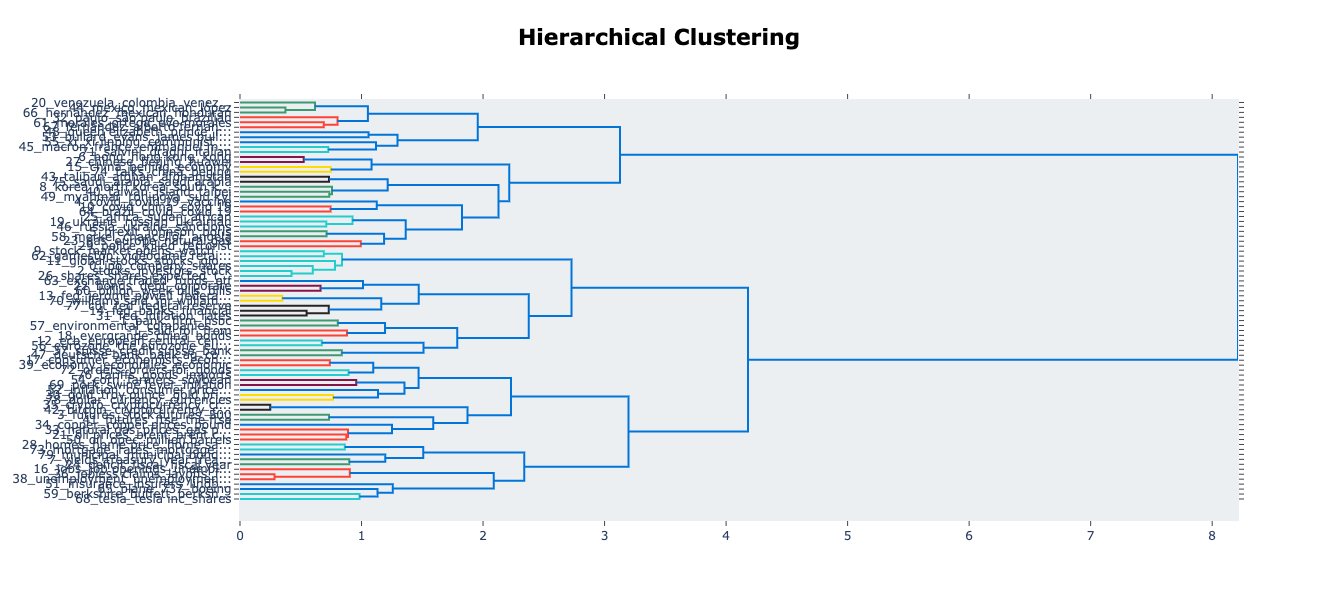

In [166]:
topic_engine.visualize_hierarchy()

In [41]:
TB_topic_res = trim_topic_dict(TB_topic_engine.topics)


## [ Core ] Research Results


> This block implements the training and testing of the topic models with varying random seeds and number of topics. 


### Model Evaluation

> Compare the performance of topic models within the training and test datasets using different evaluation metric - a. Topic Coherence (TC) and b. Topic Diversity (TD). 

- Build up a sharable CountVectorzier


In [4]:
#  /Evaluation module
from FinNLP.topicModel.topicEval import compute_topic_TC, compute_topic_diversity


In [39]:
# shared CountVectorizer
train_word_verse_counter = CountVectorizer(stop_words="english",
                                           ngram_range=(1, 2))
# Freq matrix: doc_len X word_num
train_word_frequency_mat = train_word_verse_counter.fit_transform(train_docs) 

# Test Set
test_word_verse_counter = CountVectorizer(stop_words="english",
                                           ngram_range=(1, 2))
# Freq matrix: doc_len X word_num
test_word_frequency_mat = test_word_verse_counter.fit_transform(test_docs) 


### a. Topic Coherence (TC)

* Implementation Roadmap

    1. counting of occurencies/cooccurencies

    2. calcualte topic coherence for each topic
    
    3. compute the average as final TC score



In [28]:
def eval_TC_result(tgt_dict, word_verse_counter, word_frequency_mat):
    topic_TC_list = []
    topic_word_ls = []
    for k,topic_obj in tqdm(tgt_dict.items()):
        # query the word set
        topic_word_set = [x[0] for x in topic_obj]
        # calc NPMI
        topic_NPMI = compute_topic_TC(topic_word_set, word_verse_counter, word_frequency_mat)

        topic_TC_list.append(topic_NPMI)
        topic_word_ls.append(topic_word_set)

    topic_TC_res = pd.DataFrame({'TC':topic_TC_list,
                                 'TopWords':topic_word_ls})

    # fill up the missing-words topic with the min TC score
    TC_score_vec = topic_TC_res['TC'].copy() 
    TC_score_vec[TC_score_vec.isna()] = topic_TC_res['TC'].min()
    topic_TC_res['TC'] = TC_score_vec 
    topic_TC_res.sort_values('TC', ascending=False, inplace=True)
    
    return topic_TC_res



In [42]:
# Demo: LDA and TB's TC  
TC_LDA_res =  eval_TC_result(LDA_topic_res, train_word_verse_counter, train_word_frequency_mat)
TC_TB_res =  eval_TC_result(TB_topic_res, train_word_verse_counter, train_word_frequency_mat)


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 11.14it/s]


In [43]:
TC_LDA_res['TC'].mean(), TC_TB_res['TC'].mean()


(-0.00019439489877244587, 0.23630009666400484)

Test Set Results

In [46]:
TC_LDA_test_res =  eval_TC_result(LDA_topic_res, test_word_verse_counter, test_word_frequency_mat)
TC_TB_test_res =  eval_TC_result(TB_topic_res, test_word_verse_counter, test_word_frequency_mat)

TC_LDA_test_res['TC'].mean(), TC_TB_test_res['TC'].mean()


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 56.69it/s]


(0.00911907997212941, 0.22520030218136491)

### b. Topic Diversity (TD)

In [44]:
TD_LDA_res =  compute_topic_diversity(TC_LDA_res['TopWords'].to_list())
TD_TB_res =  compute_topic_diversity(TC_TB_res['TopWords'].to_list())


In [45]:
TD_LDA_res, TD_TB_res

(0.744, 0.856)

### Topic Model Comparison on News Dataset


In [100]:
from gensim.models import LdaModel, LsiModel

# TF-IDF vectorization
train_tfidf = gensim.models.TfidfModel(train_corpus) 
# Train corpus
train_corpus_tfidf = train_tfidf[train_corpus]

# shared CountVectorizer
train_word_verse_counter = CountVectorizer(stop_words="english",
                                           ngram_range=(1, 2))
# Freq matrix: doc_len X word_num
train_word_frequency_mat = train_word_verse_counter.fit_transform(train_docs) 

# Test Set
test_word_verse_counter = CountVectorizer(stop_words="english",
                                           ngram_range=(1, 2))
# Freq matrix: doc_len X word_num
test_word_frequency_mat = test_word_verse_counter.fit_transform(test_docs) 


In [101]:
chunksize = 2000
passes = 20
iterations = 500
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make an index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token


In [102]:
random_seed_ls = [1, 2, 42]
topic_number_ls = [5, 10, 30, 50]

TC_tot_result = {}
TD_tot_result = {}

for topic_num in topic_number_ls: 
    # conduct model fitting with specific random seed: seed
    TC_num_ls, TD_num_ls = [], []
    for seed in random_seed_ls:
        print("  => Conduct topic modelling with topic numbers - {} at random seed - {}".format(topic_num, seed))
        #########   Model Fitting  #########
        # > LSI
        lsi_model = LsiModel(train_corpus_tfidf,
                             id2word=dictionary,
                             num_topics=topic_num,
                             random_seed=seed)  
        LSI_topic_word_dict = {}
        for idx in tqdm(range(topic_num)):
            ## Query the word set
            topic_obj = lsi_model.show_topic(idx)
            topic_word_set = [(x[0],abs(float(round(x[1],4)))) for x in topic_obj]
            LSI_topic_word_dict[idx] = topic_word_set[:10]
        LSI_topic_res = trim_topic_dict(LSI_topic_word_dict)

        # > LDA
        LDA_model = LdaModel(corpus=train_corpus,
                             id2word=id2word,
                             num_topics=topic_num,
                             random_state=seed,
                             chunksize=chunksize,
                             eta='auto',
                             iterations=iterations,
                             passes=passes,
                             eval_every=eval_every)
        LDA_topics = LDA_model.top_topics(train_corpus)
        LDA_topic_word_dict = {}
        for idx,topic_obj in tqdm(enumerate(LDA_topics)):
            ## Query the word set
            #  :remove stopwords
            topic_word_set = [(x[1],float(round(x[0],4))) for x in topic_obj[0]]
            LDA_topic_word_dict[idx] = topic_word_set[:10]
        LDA_topic_res = trim_topic_dict(LDA_topic_word_dict)

        # > Doc2Vec 
        Doc2Vec_model = TopicEngine(nr_topics=topic_num, random_state=seed)
        # fit the Doc2Vec Topic model with embeddings
        fit_Dtopics, fit_Dprobs = Doc2Vec_model.fit_transform(documents=train_docs,
                                                              embeddings=doc2vec_embeddings[train_ids.index])
        Dtopic_res = trim_topic_dict(Doc2Vec_model.topics)

        # > BERTopic
        BERTopic_model = TopicEngine(nr_topics=topic_num, random_state=seed)
        # fit the BERTopic model with embeddings
        fit_Btopics, fit_Bprobs = BERTopic_model.fit_transform(documents=train_docs,
                                                               embeddings=doc_raw_embeddings[train_ids.index])
        Btopic_res = trim_topic_dict(BERTopic_model.topics)

        # > ThemeBERT
        TB_topic_engine = TopicEngine(nr_topics=topic_num, random_state=seed)
        # fit with the training docs in an unsupervised clustering
        fit_topics, fit_probs = TB_topic_engine.fit_transform(documents=train_docs,
                                                              embeddings=doc_comp_embeddings[train_ids.index])
        TB_topic_res = trim_topic_dict(TB_topic_engine.topics)
        
        topic_models_res = {'LSI':LSI_topic_res,
                            'LDA':LDA_topic_res,
                            'Doc2Vec':Dtopic_res,
                            'BERTopic':Btopic_res,
                            'ThemeBERT':TB_topic_res
                           }
        ###########################################

        ########### Model Evaluation ##############
        TC_train_ls,TC_test_ls = [],[]
        TD_train_ls,TD_test_ls = [],[]
        
        for key, res in topic_models_res.items():
            TC_train_res = eval_TC_result(res, train_word_verse_counter, train_word_frequency_mat)
            TC_test_res = eval_TC_result(res, test_word_verse_counter, test_word_frequency_mat)
            
            TC_train_ls.append(TC_train_res['TC'].mean()) 
            TC_test_ls.append(TC_test_res['TC'].mean()) 
            
            TD_train_res =  compute_topic_diversity(TC_train_res['TopWords'].to_list())
            TD_test_res =  compute_topic_diversity(TC_test_res['TopWords'].to_list())
            TD_train_ls.append(TD_train_res)
            TD_test_ls.append(TD_test_res)
            
        # Summary Result  
        TC_table = pd.DataFrame({'Train':TC_train_ls, 'Test':TC_test_ls}, index = topic_models_res.keys())
        TD_table = pd.DataFrame({'TD':TD_train_ls}, index = topic_models_res.keys())
        
        TC_num_ls.append(TC_table)
        TD_num_ls.append(TD_table)
        ############################################
        
    TC_tot_result[topic_num] = TC_num_ls
    TD_tot_result[topic_num] =  TD_num_ls


  => Conduct topic modelling with topic numbers - 5 at random seed - 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 4512.92it/s]
5it [00:00, 16552.11it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 45.94it/s]


  => Conduct topic modelling with topic numbers - 5 at random seed - 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 671.88it/s]
5it [00:00, 15720.78it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 49.98it/s]


  => Conduct topic modelling with topic numbers - 5 at random seed - 42


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 3317.75it/s]
5it [00:00, 15972.22it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 45.80it/s]


  => Conduct topic modelling with topic numbers - 10 at random seed - 1


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 4549.63it/s]
10it [00:00, 17324.68it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 56.33it/s]


  => Conduct topic modelling with topic numbers - 10 at random seed - 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10821.22it/s]
10it [00:00, 17418.21it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 54.91it/s]


  => Conduct topic modelling with topic numbers - 10 at random seed - 42


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2838.59it/s]
10it [00:00, 17483.55it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 55.61it/s]


  => Conduct topic modelling with topic numbers - 30 at random seed - 1


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 5602.37it/s]
30it [00:00, 18622.04it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.20it/s]


  => Conduct topic modelling with topic numbers - 30 at random seed - 2


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 5940.38it/s]
30it [00:00, 17848.10it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.45it/s]


  => Conduct topic modelling with topic numbers - 30 at random seed - 42


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 5210.96it/s]
30it [00:00, 17251.04it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.49it/s]


  => Conduct topic modelling with topic numbers - 50 at random seed - 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 13671.13it/s]
50it [00:00, 18077.34it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 54.70it/s]


  => Conduct topic modelling with topic numbers - 50 at random seed - 2


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 3251.20it/s]
50it [00:00, 18368.68it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 53.38it/s]


  => Conduct topic modelling with topic numbers - 50 at random seed - 42


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 5135.04it/s]
50it [00:00, 15893.54it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 53.96it/s]


**TC Wrap-up**

In [120]:
topic_TC_res_ls = []

for num, top_table in TC_tot_result.items():
    topic_avg_res = (top_table[0]+top_table[1]+top_table[2])/3
    topic_avg_res['Topic Number'] = num
    
    topic_TC_res_ls.append(topic_avg_res) 
topic_TC_final_result = pd.concat(topic_TC_res_ls).reset_index()

TC_cols = topic_TC_final_result.columns.tolist()
TC_cols[0] = 'Model'
topic_TC_final_result.columns = TC_cols

**TD Wrap-up**

In [111]:
topic_TD_res_ls = []

for num, top_table in TD_tot_result.items():
    topic_avg_res = pd.DataFrame(pd.concat(top_table, axis=1).mean(axis=1), columns=['TD'])
    topic_avg_res['Topic Number'] = num
    
    topic_TD_res_ls.append(topic_avg_res) 
    
topic_TD_final_result = pd.concat(topic_TD_res_ls, axis=0).reset_index()

columns = topic_TD_final_result.columns.to_list()
columns[0] = 'Model'
topic_TD_final_result.columns = columns



In [66]:
## 🛡️Key Back-up: store the intermediate results variable
#joblib.dump(topic_TC_final_result, "study/findings/news_topic_TC.joblib")
#joblib.dump(topic_TD_final_result, "study/findings/news_topic_TD.joblib")

topic_TC_final_result = joblib.load("study/findings/news_topic_TC.joblib")
topic_TD_final_result = joblib.load("study/findings/news_topic_TD.joblib")


### Visualization

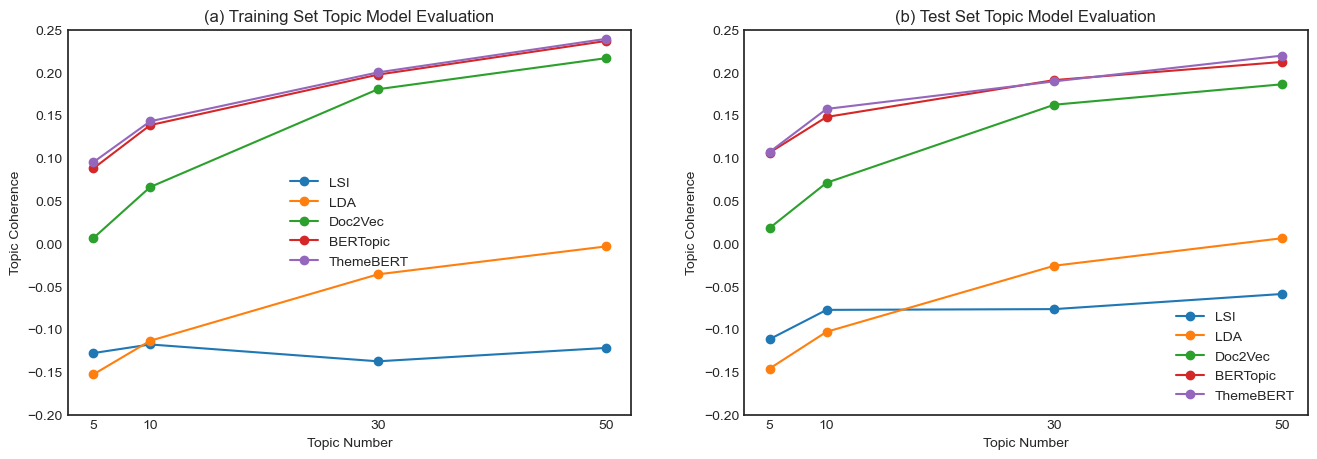

In [68]:
fig, axes = plt.subplots(ncols=2, figsize=(16,5))

ax= axes[0]
for key, grp in topic_TC_final_result.groupby(['Model'], sort=False):
    ax = grp.plot(ax=ax, kind="line", marker='o',
                  x='Topic Number', y='Train', label=key)
    ax.set_ylim([-0.2, 0.25])
    ax.set_title('(a) Training Set Topic Model Evaluation')
    ax.set_xticks([5,10,30,50])
ax.set_ylabel("Topic Coherence")

ax = axes[1]
for key, grp in topic_TC_final_result.groupby(['Model'], sort=False):
    ax = grp.plot(ax=ax, kind="line", marker='o',
                  x='Topic Number', y='Test', label=key)
    ax.set_ylim([-0.2, 0.25])
    ax.set_title('(b) Test Set Topic Model Evaluation')
    ax.set_xticks([5,10,30,50])
ax.set_ylabel("Topic Coherence")
plt.savefig('study/findings/news_TC.png', dpi=500)
plt.show()


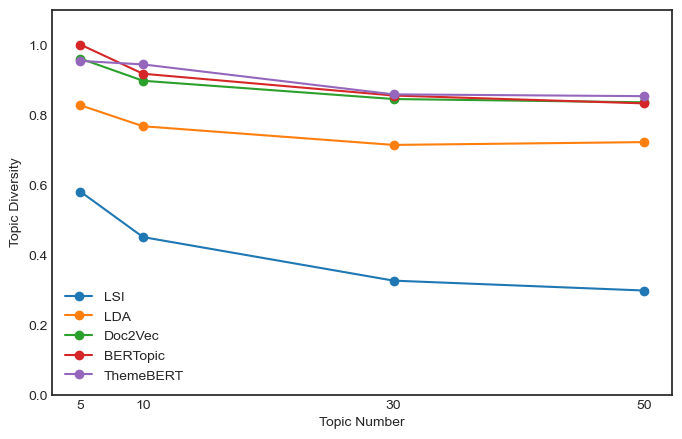

In [69]:
fig, ax = plt.subplots(figsize=(8,5))

for key, grp in topic_TD_final_result.groupby(['Model'], sort=False):
    ax = grp.plot(ax=ax, kind="line", marker='o',
                  x='Topic Number', y='TD', label=key)

ax.set_ylabel("Topic Diversity")
ax.set_ylim([0, 1.1])
#ax.set_xlim([0, 55])
ax.set_xticks([5,10,30,50])
plt.legend(loc='best')
plt.savefig('study/findings/news_TD.png', dpi=500)
plt.show()


---

### Topic Model Comparison on Benchmark Dataset: 20 Newsgroups

> This block independently implement the analysis of topic model within newsgroup dataset.

The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics split in two subsets:
    
    - one for training (or development), and
    - the other one for testing (or for performance evaluation).
    
The split between the train and test set is based upon a messages posted before and after a specific date. The newsgroup-related metadata are stripped from irrelevant text content regarded as noise.

Random sample 3,000 training data for efficiency.



In [4]:
import nltk
import gensim
# Tokenize the documents.
from nltk.tokenize import RegexpTokenizer
# Lemmatize the documents.
from nltk.stem.wordnet import WordNetLemmatizer
# Compute bigrams.
from gensim.models import Phrases
# Remove rare and common tokens.
from gensim.corpora import Dictionary
from gensim.models.doc2vec import Doc2Vec

from gensim.models import LdaModel, LsiModel


In [5]:
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'))

newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'))


In [6]:
NG_train_num = 3000
random.seed(42)
NG_train_data = random.sample(newsgroups_train['data'], NG_train_num)


**Text Data Preprocessing**

In [34]:
MAX_DOC_LEN = 200   # upper bound for document length

input_NG_doc_ls = NG_train_data + newsgroups_test['data']

# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')

NG_process_docs = []

for idx in tqdm(range(len(input_NG_doc_ls))):
    doc_idx = input_NG_doc_ls[idx].lower()  # Convert to lowercase.
    NG_process_docs.append(tokenizer.tokenize(doc_idx))  # Split into words.

# Remove numbers, but not words that contain numbers.
NG_process_docs = [[token for token in doc if not token.isnumeric()] for doc in NG_process_docs]

# Truncate the extreme long documents to below MAX_DOC_LEN
NG_process_docs = [[token for token in doc[:MAX_DOC_LEN]] for doc in NG_process_docs]


100%|███████████████████████████████████████████████████████████████████████████████████████| 10532/10532 [00:00<00:00, 36761.22it/s]


In [38]:
# Lemmatize the documents, 
lemmatizer = WordNetLemmatizer()

# Remove words that are only one character.
NG_lemmatized_docs = [[token for token in doc if len(token) > 1] for doc in NG_process_docs]
# Remove stopwords 
NG_lemmatized_docs = [[token for token in doc if token not in ENGLISH_STOP_WORDS] for doc in NG_lemmatized_docs]
NG_lemmatized_docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in NG_lemmatized_docs]

# Train & Test Output Docs
NG_train_doc_tokens = []
NG_test_doc_tokens = []

NG_train_ids = np.array(range(NG_train_num ))
NG_test_ids =  np.array(range(NG_train_num, len(input_NG_doc_ls)))

for x_id in NG_train_ids:
    NG_train_doc_tokens.append(NG_lemmatized_docs[x_id])

for y_id in NG_test_ids:
    NG_test_doc_tokens.append(NG_lemmatized_docs[y_id])
    
# Create a dictionary representation of the documents.
#  [⚠️] within training set
NG_dictionary = Dictionary(NG_train_doc_tokens)
# Filter out words that occur less than 20 documents or above 50%
NG_dictionary.filter_extremes(no_below=20, no_above=0.5)


# Bag-of-words representation of the documents.
NG_corpus = [NG_dictionary.doc2bow(doc) for doc in NG_lemmatized_docs]

NG_train_corpus = [NG_dictionary.doc2bow(doc) for doc in NG_train_doc_tokens]
NG_test_corpus = [NG_dictionary.doc2bow(doc) for doc in NG_test_doc_tokens]

temp = NG_dictionary[0] 
NG_id2word = NG_dictionary.id2token

print('Number of unique tokens: %d' % len(NG_dictionary))
print('Number of documents: %d' % len(NG_corpus))


Number of unique tokens: 1137
Number of documents: 10532


In [9]:
## Core Input Variable
NG_input_doc_ls = [' '.join(doc) for doc in NG_process_docs]

NG_train_docs, NG_test_docs =  NG_input_doc_ls[:NG_train_num], NG_input_doc_ls[NG_train_num:]


**Document Embeddings**

- Doc2Vec: `NG_doc2vec_embeddings` 

- BERTopic: `NG_raw_embeddings ` 

- ThemeBERT: `NG_comp_embeddings ` 


In [17]:
NG_theme_BERT_model = ThemeBERT()


2023-01-05 01:25:41,246 - FinNLP -  => 🚀Launching the ThemeBERT model with PLM embedding engine [all-MiniLM-L6-v2] ...


> Doc2Vec Embeddings

In [18]:
random.seed(42)
doc2vec_model = Doc2Vec(vector_size=384,   # latent doc embeddings
                        min_count=2,   # min word count
                        epochs=30,   # training epochs
                       )

## Generate the training & test set
def gensim_read_corpus(docs, tokens_only=False):
    for i, doc in enumerate(docs):
        tokens = doc
        if tokens_only:
            yield tokens
        else:
            # For training data, add tags (
            yield gensim.models.doc2vec.TaggedDocument(tokens, [i])

NG_train_gensim_corpus = list(gensim_read_corpus(NG_train_doc_tokens))
NG_test_gensim_corpus = list(gensim_read_corpus(NG_test_doc_tokens, tokens_only=True))    

#### Doc2Vec Model Fitting #### 
# Step 1. Build a vocabulary
doc2vec_model.build_vocab(NG_train_gensim_corpus)
# Step 2. Training the Doc2Vec Model
doc2vec_model.train(NG_train_gensim_corpus,
                    total_examples=doc2vec_model.corpus_count,
                    epochs=doc2vec_model.epochs)

## Generate Doc2Vec Embeddings
NG_doc2vec_embedding_ls = []
for doc in tqdm(NG_lemmatized_docs):
    doc2vec_vector = doc2vec_model.infer_vector(doc)
    
    NG_doc2vec_embedding_ls.append(doc2vec_vector)
    
# Output document embeddings
NG_doc2vec_embeddings = np.stack(NG_doc2vec_embedding_ls)


100%|█████████████████████████████████████████████████████████████████████████████████████████| 10532/10532 [00:23<00:00, 448.74it/s]


> BERTopic & ThemeBERT Embeddings

In [19]:
# Keyphrase Extraction
NG_doc_process_ls = NG_theme_BERT_model.encode(NG_input_doc_ls,
                                               flag_doc=True, flag_summary=False, flag_entity=False,
                                               keyphrase_ngram_range=(1,2))


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [14:24<00:00,  5.24s/it]


In [21]:
# Embedding model: sentence-transformer
NG_embed_model = NG_theme_BERT_model.model
# BERTopic
NG_raw_embeddings = NG_embed_model.embed(NG_input_doc_ls, verbose=True)

# ThemeBERT
NG_comp_embeddings = NG_theme_BERT_model.embed_documents(NG_doc_process_ls)


Batches:   0%|          | 0/330 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 10532/10532 [03:34<00:00, 49.15it/s]


In [48]:
## 🛡️Back-up: store the intermediate data variable
#joblib.dump(NG_doc2vec_embeddings, "data/output/tmp_NG_doc2vec_embeddings.joblib")
#joblib.dump(NG_raw_embeddings, "data/output/tmp_NG_raw_embeddings.joblib")
#joblib.dump(NG_comp_embeddings, "data/output/tmp_NG_comp_embeddings.joblib")

NG_doc2vec_embeddings = joblib.load("data/output/tmp_NG_doc2vec_embeddings.joblib")
NG_raw_embeddings = joblib.load("data/output/tmp_NG_raw_embeddings.joblib")
NG_comp_embeddings = joblib.load("data/output/tmp_NG_comp_embeddings.joblib")


**Prepare Training & Test Input Data**

TF-IDF matrix

In [11]:
# TF-IDF vectorization
NG_train_tfidf = gensim.models.TfidfModel(NG_train_corpus) 
# Train corpus
NG_train_corpus_tfidf = NG_train_tfidf[NG_train_corpus]

# shared CountVectorizer
train_word_verse_counter = CountVectorizer(stop_words="english",
                                           ngram_range=(1, 2))
# Freq matrix: doc_len X word_num
train_word_frequency_mat = train_word_verse_counter.fit_transform(NG_train_docs) 

# Test Set
test_word_verse_counter = CountVectorizer(stop_words="english",
                                           ngram_range=(1, 2))
# Freq matrix: doc_len X word_num
test_word_frequency_mat = test_word_verse_counter.fit_transform(NG_test_docs) 


**Model Fitting & Evaluation**

In [16]:
def eval_TC_result(tgt_dict, word_verse_counter, word_frequency_mat):
    topic_TC_list = []
    topic_word_ls = []
    for k,topic_obj in tqdm(tgt_dict.items()):
        # query the word set
        topic_word_set = [x[0] for x in topic_obj]
        # calc NPMI
        topic_NPMI = compute_topic_TC(topic_word_set, word_verse_counter, word_frequency_mat)

        topic_TC_list.append(topic_NPMI)
        topic_word_ls.append(topic_word_set)

    topic_TC_res = pd.DataFrame({'TC':topic_TC_list,
                                 'TopWords':topic_word_ls})

    # fill up the missing-words topic with the min TC score
    TC_score_vec = topic_TC_res['TC'].copy() 
    TC_score_vec[TC_score_vec.isna()] = topic_TC_res['TC'].min()
    topic_TC_res['TC'] = TC_score_vec 
    topic_TC_res.sort_values('TC', ascending=False, inplace=True)
    
    return topic_TC_res

# trim the topic into dictionary format
def trim_topic_dict(topic_dict):
    topic_processed_dict = {}
    for key,val in topic_dict.items():
        if key<0:
            continue
        val_cleaned = [(pair[0], round(pair[1],4)) for pair in val]
        topic_processed_dict[key] = val_cleaned
    return topic_processed_dict


In [51]:
random_seed_ls = [1, 2, 42]
topic_number_ls = [5, 10, 15, 20]

TC_tot_result = {}
TD_tot_result = {}

#### Model Hyperparam ####
chunksize = 2000
passes = 20
iterations = 500
eval_every = None  # Don't evaluate model perplexity, takes too much time.
############################

for topic_num in topic_number_ls: 
    # conduct model fitting with specific random seed: seed
    TC_num_ls, TD_num_ls = [], []
    for seed in random_seed_ls:
        print("  => Conduct topic modelling with topic numbers - {} at random seed - {}".format(topic_num, seed))
        #########   Model Fitting  #########
        # > LSI
        print(" --@LSI model is running")
        lsi_model = LsiModel(NG_train_corpus_tfidf,
                             id2word=NG_dictionary,
                             num_topics=topic_num,
                             random_seed=seed)  
        LSI_topic_word_dict = {}
        for idx in tqdm(range(topic_num)):
            ## Query the word set
            topic_obj = lsi_model.show_topic(idx)
            topic_word_set = [(x[0],abs(float(round(x[1],4)))) for x in topic_obj]
            LSI_topic_word_dict[idx] = topic_word_set[:10]
        LSI_topic_res = trim_topic_dict(LSI_topic_word_dict)

        # > LDA
        print(" --@LDA model is running")
        LDA_model = LdaModel(corpus=NG_train_corpus,
                             id2word=NG_id2word,
                             num_topics=topic_num,
                             random_state=seed,
                             chunksize=chunksize,
                             eta='auto',
                             iterations=iterations,
                             passes=passes,
                             eval_every=eval_every)
        LDA_topics = LDA_model.top_topics(NG_train_corpus)
        LDA_topic_word_dict = {}
        for idx,topic_obj in tqdm(enumerate(LDA_topics)):
            ## Query the word set
            #  :remove stopwords
            topic_word_set = [(x[1],float(round(x[0],4))) for x in topic_obj[0]]
            LDA_topic_word_dict[idx] = topic_word_set[:10]
        LDA_topic_res = trim_topic_dict(LDA_topic_word_dict)

        # > Doc2Vec 
        print(" --@Doc2Vec model is running")
        Doc2Vec_model = TopicEngine(nr_topics=topic_num, random_state=seed)
        # fit the Doc2Vec Topic model with embeddings
        fit_Dtopics, fit_Dprobs = Doc2Vec_model.fit_transform(documents=NG_train_docs,
                                                              embeddings=NG_doc2vec_embeddings[NG_train_ids])
        Dtopic_res = trim_topic_dict(Doc2Vec_model.topics)

        # > BERTopic
        print(" --@BERTopic model is running")
        BERTopic_model = TopicEngine(nr_topics=topic_num, random_state=seed)
        # fit the BERTopic model with embeddings
        fit_Btopics, fit_Bprobs = BERTopic_model.fit_transform(documents=NG_train_docs,
                                                               embeddings=NG_raw_embeddings[NG_train_ids])
        Btopic_res = trim_topic_dict(BERTopic_model.topics)

        # > ThemeBERT
        TB_topic_engine = TopicEngine(nr_topics=topic_num, random_state=seed)
        # fit with the training docs in an unsupervised clustering
        fit_topics, fit_probs = TB_topic_engine.fit_transform(documents=NG_train_docs,
                                                              embeddings=NG_comp_embeddings[NG_train_ids])
        TB_topic_res = trim_topic_dict(TB_topic_engine.topics)
        
        topic_models_res = {'LSI':LSI_topic_res,
                            'LDA':LDA_topic_res,
                            'Doc2Vec':Dtopic_res,
                            'BERTopic':Btopic_res,
                            'ThemeBERT':TB_topic_res
                           }
        ###########################################

        ########### Model Evaluation ##############
        TC_train_ls,TC_test_ls = [],[]
        TD_train_ls,TD_test_ls = [],[]
        
        for key, res in topic_models_res.items():
            TC_train_res = eval_TC_result(res, train_word_verse_counter, train_word_frequency_mat)
            TC_test_res = eval_TC_result(res, test_word_verse_counter, test_word_frequency_mat)
            
            TC_train_ls.append(TC_train_res['TC'].mean()) 
            TC_test_ls.append(TC_test_res['TC'].mean()) 
            
            TD_train_res =  compute_topic_diversity(TC_train_res['TopWords'].to_list())
            TD_test_res =  compute_topic_diversity(TC_test_res['TopWords'].to_list())
            TD_train_ls.append(TD_train_res)
            TD_test_ls.append(TD_test_res)
            
        # Summary Result  
        TC_table = pd.DataFrame({'Train':TC_train_ls, 'Test':TC_test_ls}, index = topic_models_res.keys())
        TD_table = pd.DataFrame({'TD':TD_train_ls}, index = topic_models_res.keys())
        
        TC_num_ls.append(TC_table)
        TD_num_ls.append(TD_table)
        ############################################
        
    TC_tot_result[topic_num] = TC_num_ls
    TD_tot_result[topic_num] =  TD_num_ls



  => Conduct topic modelling with topic numbers - 5 at random seed - 1
 --@LSI model is running


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 5236.33it/s]

 --@LDA model is running



5it [00:00, 15827.56it/s]


 --@Doc2Vec model is running
 --@BERTopic model is running


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.48it/s]


  => Conduct topic modelling with topic numbers - 5 at random seed - 2
 --@LSI model is running


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 5347.15it/s]


 --@LDA model is running


5it [00:00, 15827.56it/s]


 --@Doc2Vec model is running
 --@BERTopic model is running


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.23it/s]


  => Conduct topic modelling with topic numbers - 5 at random seed - 42
 --@LSI model is running


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 3293.78it/s]


 --@LDA model is running


5it [00:00, 14968.97it/s]


 --@Doc2Vec model is running
 --@BERTopic model is running


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.25it/s]


  => Conduct topic modelling with topic numbers - 10 at random seed - 1
 --@LSI model is running


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 4382.30it/s]


 --@LDA model is running


10it [00:00, 13604.62it/s]


 --@Doc2Vec model is running
 --@BERTopic model is running


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.80it/s]


  => Conduct topic modelling with topic numbers - 10 at random seed - 2
 --@LSI model is running


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 4712.70it/s]


 --@LDA model is running


10it [00:00, 17063.89it/s]


 --@Doc2Vec model is running
 --@BERTopic model is running


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.68it/s]


  => Conduct topic modelling with topic numbers - 10 at random seed - 42
 --@LSI model is running


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 5652.70it/s]


 --@LDA model is running


10it [00:00, 17483.55it/s]


 --@Doc2Vec model is running
 --@BERTopic model is running


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.96it/s]


  => Conduct topic modelling with topic numbers - 15 at random seed - 1
 --@LSI model is running


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 5385.60it/s]


 --@LDA model is running


15it [00:00, 18337.09it/s]


 --@Doc2Vec model is running
 --@BERTopic model is running


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 12.17it/s]


  => Conduct topic modelling with topic numbers - 15 at random seed - 2
 --@LSI model is running


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 1245.71it/s]


 --@LDA model is running


15it [00:00, 16871.70it/s]


 --@Doc2Vec model is running
 --@BERTopic model is running


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 12.87it/s]


  => Conduct topic modelling with topic numbers - 15 at random seed - 42
 --@LSI model is running


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 4769.51it/s]


 --@LDA model is running


15it [00:00, 17447.19it/s]


 --@Doc2Vec model is running
 --@BERTopic model is running


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 13.85it/s]


  => Conduct topic modelling with topic numbers - 20 at random seed - 1
 --@LSI model is running


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 17123.10it/s]


 --@LDA model is running


20it [00:00, 17924.38it/s]


 --@Doc2Vec model is running
 --@BERTopic model is running


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 13.02it/s]


  => Conduct topic modelling with topic numbers - 20 at random seed - 2
 --@LSI model is running


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 4711.38it/s]


 --@LDA model is running


20it [00:00, 13879.23it/s]


 --@Doc2Vec model is running
 --@BERTopic model is running


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 13.58it/s]


  => Conduct topic modelling with topic numbers - 20 at random seed - 42
 --@LSI model is running


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 4861.27it/s]


 --@LDA model is running


20it [00:00, 18051.66it/s]


 --@Doc2Vec model is running
 --@BERTopic model is running


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 13.88it/s]


Wrap-up Results

In [52]:
topic_TC_res_ls = []

for num, top_table in TC_tot_result.items():
    topic_avg_res = (top_table[0]+top_table[1]+top_table[2])/3
    topic_avg_res['Topic Number'] = num
    
    topic_TC_res_ls.append(topic_avg_res) 
topic_TC_final_result = pd.concat(topic_TC_res_ls).reset_index()

TC_cols = topic_TC_final_result.columns.tolist()
TC_cols[0] = 'Model'
topic_TC_final_result.columns = TC_cols


topic_TD_res_ls = []

for num, top_table in TD_tot_result.items():
    topic_avg_res = pd.DataFrame(pd.concat(top_table, axis=1).mean(axis=1), columns=['TD'])
    topic_avg_res['Topic Number'] = num
    
    topic_TD_res_ls.append(topic_avg_res) 
    
topic_TD_final_result = pd.concat(topic_TD_res_ls, axis=0).reset_index()

columns = topic_TD_final_result.columns.to_list()
columns[0] = 'Model'
topic_TD_final_result.columns = columns



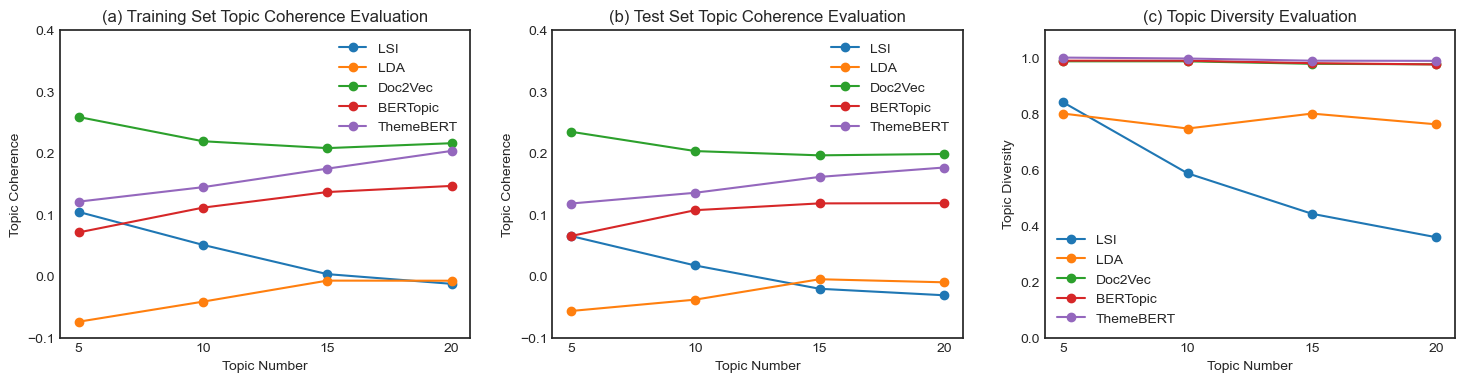

In [65]:
fig, axes = plt.subplots(ncols=3, figsize=(18,4))

ax= axes[0]
for key, grp in topic_TC_final_result.groupby(['Model'], sort=False):
    ax = grp.plot(ax=ax, kind="line", marker='o',
                  x='Topic Number', y='Train', label=key)
    ax.set_ylim([-0.1, 0.4])
    ax.set_title('(a) Training Set Topic Coherence Evaluation')
    ax.set_xticks([5,10,15,20])
ax.set_ylabel("Topic Coherence")

ax = axes[1]
for key, grp in topic_TC_final_result.groupby(['Model'], sort=False):
    ax = grp.plot(ax=ax, kind="line", marker='o',
                  x='Topic Number', y='Test', label=key)
    ax.set_ylim([-0.1, 0.4])
    ax.set_title('(b) Test Set Topic Coherence Evaluation')
    ax.set_xticks([5,10,15,20])
ax.set_ylabel("Topic Coherence")

ax= axes[2]
for key, grp in topic_TD_final_result.groupby(['Model'], sort=False):
    ax = grp.plot(ax=ax, kind="line", marker='o',
                  x='Topic Number', y='TD', label=key)

ax.set_title('(c) Topic Diversity Evaluation')
ax.set_ylabel("Topic Diversity")
ax.set_ylim([0, 1.1])
#ax.set_xlim([0, 55])
ax.set_xticks([5,10,15,20])
plt.legend(loc='best')

plt.savefig('study/findings/news20_topic.png', dpi=500)
plt.show()


---


<div style="padding:16px;color:white;margin:0;font-size:150%;text-align:left;display:fill;border-radius:5px;background-color:#003E74;overflow:hidden"> <center><strong>Section III: Practical Application</strong></center></div>

# [ Core ] Application

> This section showcases how to leverage the fitted ThemeBERT model to identify themes from news text data and generate theme time series index  


## a. Theme Identification

Topic 1 belongs to the Covid-19 theme. Generate the tracker of the Covid-19 theme.


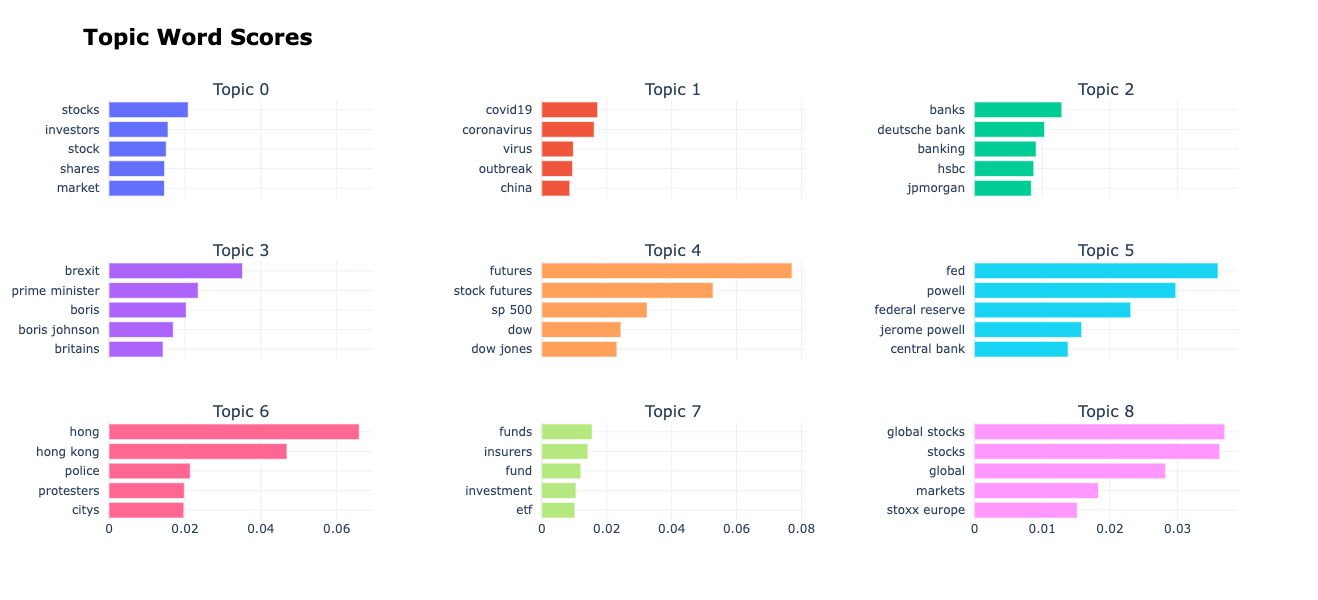

In [153]:
# > ThemeBERT on the real financial news dataset
# if run the evaluation of the previous section, could directly use the fitted model object
TB_topic_engine = TopicEngine(nr_topics=50, random_state=42)

# Fit with the training docs in an unsupervised clustering
fit_topics, fit_probs = TB_topic_engine.fit_transform(documents=train_docs,
                                                      embeddings=doc_comp_embeddings[train_ids.index])

# Visualize the top topics identified by the algo
TB_topic_engine.visualize_barchart(top_n_topics=9)

In [158]:
output_data = news_research_data[['DATE', 'NewsGroup','NewsCategory', 'NewsHeadline','NewsStory']].copy()


In [160]:
# Covid-19 theme
theme_embedding = TB_topic_engine.topic_embeddings[1:][1]


**Theme Exposure** 

In [161]:
topic_exp_TB = cosine_similarity(doc_comp_embeddings, theme_embedding.reshape(1,-1))

# Raw Similarity
output_data['Covid Similarity'] = topic_exp_TB 


In [162]:
def theme_transform_exposure(cos_sim_vec, low_threshold, upper_bound):
    """convert the raw cosine similarity into (0,1) exposure"""
    exposure_vec = cos_sim_vec.copy()
    # filter irrelevant exposure
    exposure_vec[exposure_vec<=low_threshold] = low_threshold
    
    bound_scaler = upper_bound-low_threshold
    exposure_vec = (exposure_vec-low_threshold)/bound_scaler 
    exposure_vec[exposure_vec>=1] = 1
    
    return exposure_vec


In [163]:
output_data['Covid Exposure'] = theme_transform_exposure(topic_exp_TB, 0.35, 0.6)


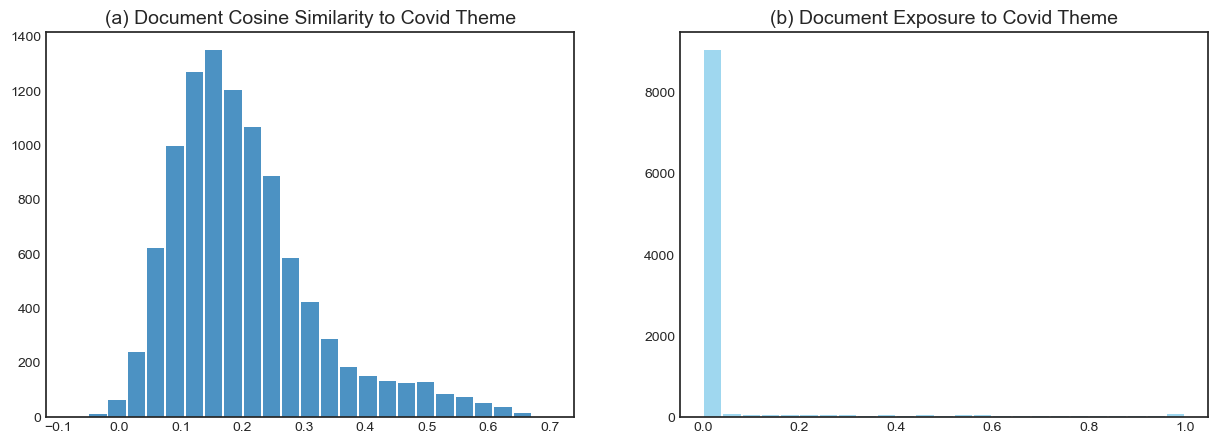

In [296]:
fig, axes = plt.subplots(ncols=2, figsize=(15,5))

ax = output_data['Covid Similarity'].hist(rwidth=.9, bins=25, ax=axes[0], alpha=.8)
ax.grid(False)
ax.set_title('(a) Document Cosine Similarity to Covid Theme',
             fontdict={'fontsize':14})

ax2 = output_data['Covid Exposure'].hist(rwidth=.9, bins=25, ax=axes[1], color='skyblue', alpha=.8)
ax2.grid(False)
_ = ax2.set_title('(b) Document Exposure to Covid Theme',
                  fontdict={'fontsize':14})

plt.savefig('study/findings/Covid_theme_exposure.png', dpi=500)
plt.show()


In [170]:
# Keep the Covid-19 relevant news data
covid_news_data = output_data.loc[output_data['Covid Exposure']>0]


## b. Theme Trend Tracker 

The theme trend $trend_t$ at given time interval $t$ is defined as the product of theme intensity and theme polarity. 

$$
{trend}_t = {intensity}_t \times {polarity}_t
$$

The tracker frequency is set up to be weekly, specifically, during Friday-to-Friday time interval. 


1. Theme Intensity

In [171]:
tot_count_ts = output_data.resample('W-Fri', on='DATE')['NewsHeadline'].count()
covid_intensity_ts = covid_news_data.resample('W-Fri', on='DATE')['Covid Exposure'].sum()/tot_count_ts


2. Theme Polarity

> FinBERT News Classification Model

[FinBERT](https://arxiv.org/abs/1908.10063) is a pre-trained NLP model to analyze sentiment of financial text. It is built by further training the BERT language model in the finance domain, using a large financial corpus and thereby fine-tuning it for financial sentiment classification. Financial PhraseBank by Malo et al. (2014) is used for fine-tuning.


In [174]:
from transformers import BertTokenizer, BertForSequenceClassification
from scipy.special import softmax

sentiment_engine = BertForSequenceClassification.from_pretrained("ProsusAI/finbert")
tokenizer = BertTokenizer.from_pretrained("ProsusAI/finbert")


In [182]:
news_story_series = covid_news_data['NewsHeadline'] + '. ' + covid_news_data['NewsStory']
news_story_ls = news_story_series.tolist()


In [207]:
batch_size = 32

news_sent_ls = []

for batch_idx in tqdm(range(0, len(news_story_ls), batch_size)):
    input_news_batch = tokenizer(news_story_ls[batch_idx:(batch_idx+batch_size)],
                                 return_tensors="pt",
                                 padding=True)  
    # Compute the sentiment 
    tensor_output = sentiment_engine(**input_news_batch)[0]

    sent_output_batch = pd.DataFrame(softmax(tensor_output.detach().numpy(), axis=1),
                                     columns=['Pos', 'Neg', 'Neutral'])
    news_sent_ls.append(sent_output_batch)
covid_news_sent = pd.concat(news_sent_ls)
covid_news_sent.index = covid_news_data.index


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [01:23<00:00,  2.52s/it]


In [227]:
covid_news_sent['Polarity'] = covid_news_sent['Pos'] - covid_news_sent['Neg']

# neutral news (maximal probability to neutral category)
bool_neutral = covid_news_sent[['Pos', 'Neg', 'Neutral']].apply(lambda arr: arr.argmax(), axis=1)==2
covid_news_sent['Polarity'][bool_neutral] = 0 

covid_news_data = covid_news_data.join(covid_news_sent['Polarity'])

2. Theme Sentiment Weekly Aggregation

Apply the median news sentiment score in the trailing one week.


In [273]:
covid_polar_ts = covid_news_data.resample('W-Fri', on='DATE')['Polarity'].median().fillna(0)


## Theme Trend Visualization

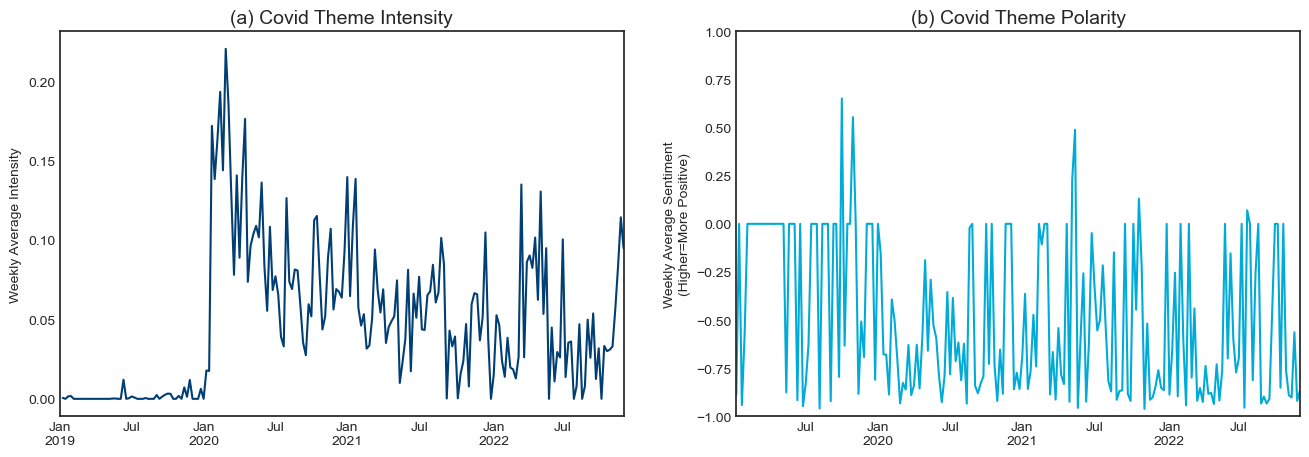

In [289]:
fig, axes = plt.subplots(ncols=2, figsize=(16,5))

ax = covid_intensity_ts.plot(color='#003E74', ax=axes[0])
ax.set_title("(a) Covid Theme Intensity", fontdict={'fontsize':14})
ax.set_ylabel("Weekly Average Intensity")
_ = ax.set_xlabel("")

ax = covid_polar_ts.plot(color='#00ACD7', ax=axes[1])
ax.set_title("(b) Covid Theme Polarity", fontdict={'fontsize':14})
ax.set_ylabel("Weekly Average Sentiment\n(Higher=More Positive)")
ax.set_ylim([-1,1])
_ = ax.set_xlabel("")

plt.savefig('study/findings/Covid_theme_indices.png', dpi=500)
plt.show()


In [271]:
covid_tracker_ts = covid_polar_ts*covid_intensity_ts


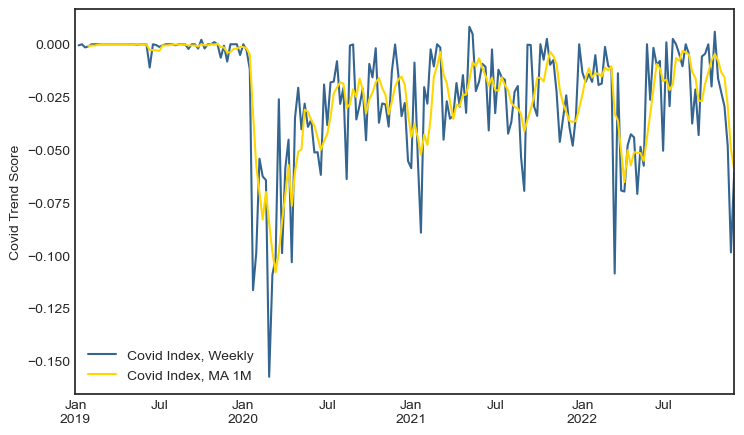

In [297]:
fig, ax = plt.subplots(figsize=(8.5,5))
ax = covid_tracker_ts.plot(color='#003E74', ax=ax, label='Covid Index, Weekly', alpha=.8)
# rolling 1-month 
covid_tracker_ts.rolling(4).mean().plot(ax=ax, color='gold',
                                         label='Covid Index, MA 1M')
ax.set_ylabel("Covid Trend Score")
ax.legend()
_ = ax.set_xlabel("")

plt.savefig('study/findings/Covid_theme_trend.png', dpi=500)
plt.show()
